# Visual Odometry for Localization in Autonomous Driving

Estimating autonomous vehicle trajectory by images taken with a monocular camera set up on the vehicle.


**Steps:**
- Extract  features from the photographs  taken with a camera setup on the vehicle.
- Use the extracted features to find matches between the features in different photographs.
- Use the found matches to estimate the camera motion between subsequent photographs. 
- Use the estimated camera motion to build the vehicle trajectory.



In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from m2bk import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)
#np.set_printoptions(threshold=np.nan)

## 0 - Loading and Visualizing the Data
There is a convenient dataset handler class to read and iterate through samples taken from the CARLA simulator. Run the following code to create a dataset handler object. 

In [3]:
dataset_handler = DatasetHandler()

The dataset handler contains 52 data frames. Each frame contains an RGB image and a depth map taken with a setup on the vehicle and a grayscale version of the RGB image which will be used for computation. Furthermore, camera calibration matrix K is also provided in the dataset handler.

Upon creation of the dataset handler object, all the frames will be automatically read and loaded. The frame content can be accessed by using `images`, `images_rgb`, `depth_maps` attributes of the dataset handler object along with the index of the requested frame. See how to access the images (grayscale), rgb images (3-channel color), depth maps and camera calibration matrix in the example below.

**Note (Depth Maps)**: Maximum depth distance is 1000. This value of depth shows that the selected pixel is at least 1000m (1km) far from the camera, however the exact distance of this pixel from the camera is unknown. Having this kind of points in further trajectory estimation might affect the trajectory precision.

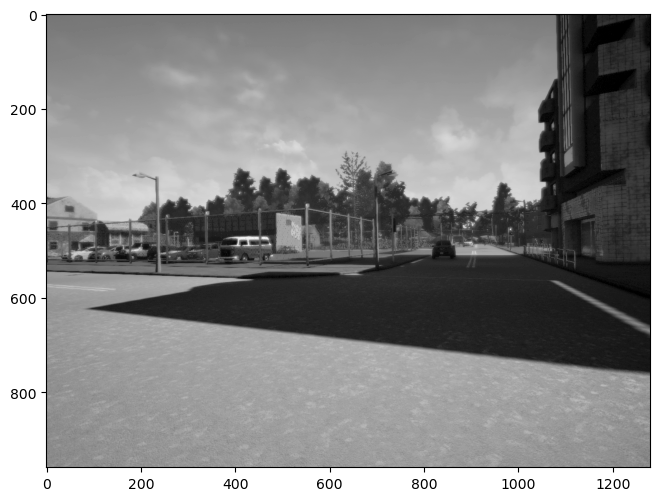

In [4]:
image = dataset_handler.images[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

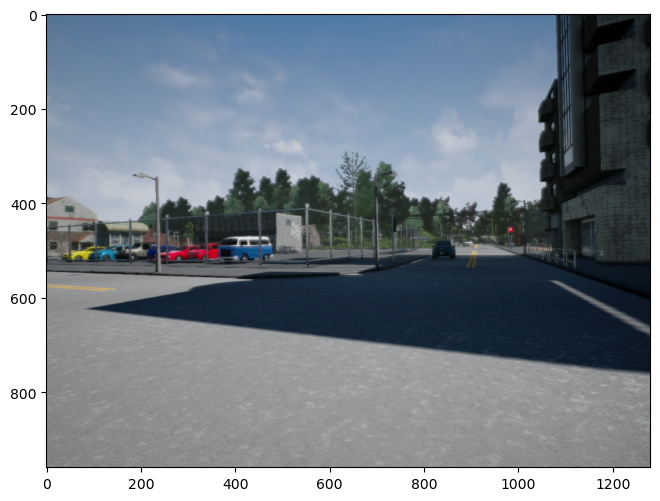

In [5]:
image_rgb = dataset_handler.images_rgb[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)

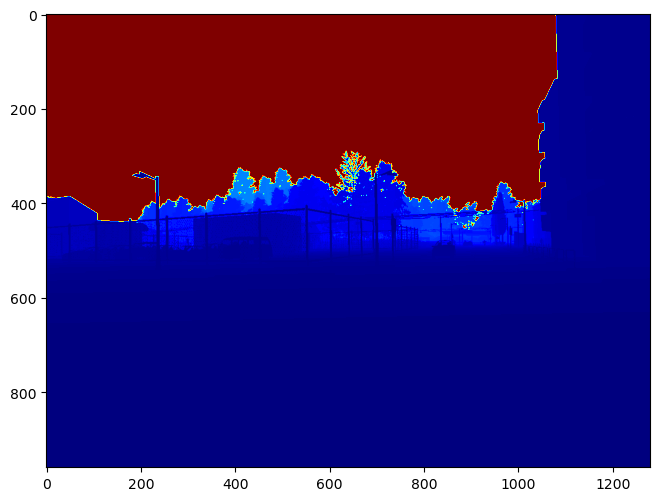

In [6]:
i = 0
depth = dataset_handler.depth_maps[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth, cmap='jet')

In [7]:
print("Depth map shape: {0}".format(depth.shape))

v, u = depth.shape
depth_val = depth[v-1, u-1]
print("Depth value of the very bottom-right pixel of depth map {0} is {1:0.3f}".format(i, depth_val))

Depth map shape: (960, 1280)
Depth value of the very bottom-right pixel of depth map 0 is 1.862


In [8]:
dataset_handler.k

array([[640.,   0., 640.],
       [  0., 480., 480.],
       [  0.,   0.,   1.]], dtype=float32)

In order to access an arbitrary frame use image index, as shown in the examples below. Make sure the indexes are within the number of frames in the dataset. The number of frames in the dataset can be accessed with num_frames attribute.

In [19]:
# Number of frames in the dataset
print(dataset_handler.num_frames)

52


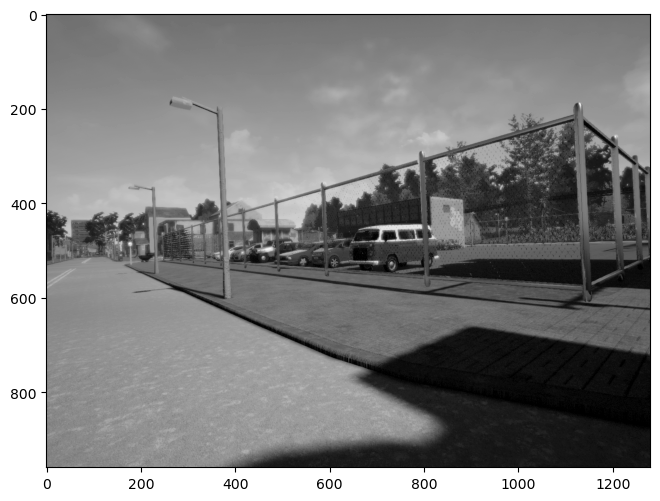

In [20]:
i = 30
image = dataset_handler.images[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

## 1 - Feature Extraction

### 1.1 - Extracting Features from an Image

Implement feature extraction from a single image.

You might find [OpenCV: Keypoint Class Description](https://docs.opencv.org/3.4.3/d2/d29/classcv_1_1KeyPoint.html) handy.

There is a function to visualise the features detected.

You might find this link useful:  [OpenCV:Feature Detection and Description](https://docs.opencv.org/3.4.3/db/d27/tutorial_py_table_of_contents_feature2d.html). 

In [22]:
def extract_features(image):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    
    ### START CODE HERE ### 
    orb = cv.ORB_create()
    kp = orb.detect(image,None)
    # compute the descriptors with ORB
    kp, des = orb.compute(image, kp)
    """
 
    
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(image,None)
    """
    surf = cv.xfeatures2d.SURF_create(600)
    # Find keypoints and descriptors directly
    kp, des = surf.detectAndCompute(image,None)
    
    # Initiate FAST detector
    star = cv.xfeatures2d.StarDetector_create()
    # Initiate BRIEF extractor
    brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
    # find the keypoints with STAR
    kp = star.detect(image,None)
    # compute the descriptors with BRIEF
    kp, des = brief.compute(image, kp)
    """


    
    
    return kp, des

In [23]:
i = 0
image = dataset_handler.images[i]
kp, des = extract_features(image)
print("Number of features detected in frame {0}: {1}\n".format(i, len(kp)))

print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kp[0].pt)))

Number of features detected in frame 0: 1508

Coordinates of the first keypoint in frame 0: (4.180478096008301, 457.4769287109375)


In [24]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(display)

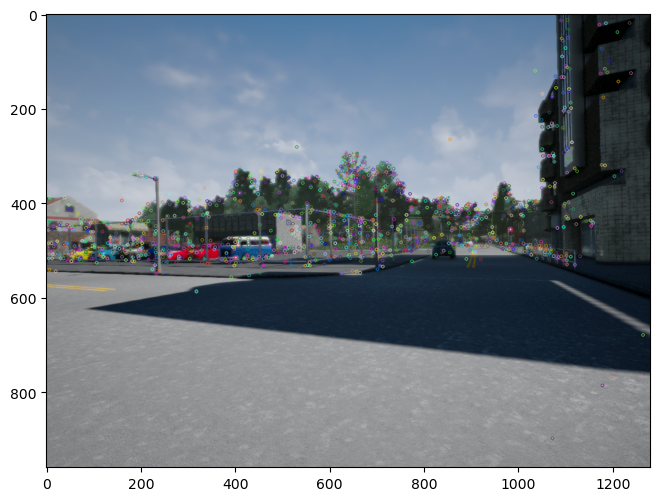

In [25]:
# Optional: visualizing and experimenting with various feature descriptors
i = 0
image = dataset_handler.images_rgb[i]

visualize_features(image, kp)

### 1.2 - Extracting Features from Each Image in the Dataset


In [26]:
def extract_features_dataset(images, extract_features_function):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    
    """
    kp_list = []
    des_list = []
    
    ### START CODE HERE ###
    for img in images:
        kp, des = extract_features(img)
        kp_list.append(kp)
        des_list.append(des)
    ### END CODE HERE ###
    
    return kp_list, des_list

In [27]:
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

i = 0
print("Number of features detected in frame {0}: {1}".format(i, len(kp_list[i])))
print("Coordinates of the first keypoint in frame {0}: {1}\n".format(i, str(kp_list[i][0].pt)))

# Remember that the length of the returned by dataset_handler lists should be the same as the length of the image array
print("Length of images array: {0}".format(len(images)))

Number of features detected in frame 0: 1508
Coordinates of the first keypoint in frame 0: (4.180478096008301, 457.4769287109375)

Length of images array: 52


## 2 - Feature Matching



### 2.1 - Matching Features from a Pair of Subsequent Frames

Implement feature matching for a pair of images. You can use any feature matching algorithm of your choice covered in the lectures, Brute Force Matching or FLANN based Matching for example.



In [28]:
def match_features(des1, des2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    ### START CODE HERE ###
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    
    flann = cv2.FlannBasedMatcher(index_params,search_params)

    match = flann.knnMatch(des1,des2,k=2)
    ### END CODE HERE ###

    return match

In [29]:
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(match)))

# Remember that a matcher finds the best matches for EACH descriptor from a query set

Number of features matched in frames 0 and 1: 1508


In [30]:
# Optional
def filter_matches_distance(match, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    
    ### START CODE HERE ###
#     filtered_match = [[0,0] for i in xrange(len(match))]
    for i,(m,n) in enumerate(match):
        if m.distance < dist_threshold*n.distance:
            filtered_match.append(m)
    ### END CODE HERE ###

    return filtered_match

In [31]:
# Optional
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]
match = match_features(des1, des2)

dist_threshold = 0.6
filtered_match = filter_matches_distance(match, dist_threshold)

print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_match)))

Number of features matched in frames 0 and 1 after filtering by distance: 408


In [32]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
#     image_matches = cv2.drawMatches(image1,kp1,image2,kp2,match,None)
    image_matches = cv2.drawMatches(image1,kp1,image2,kp2,match,None,flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

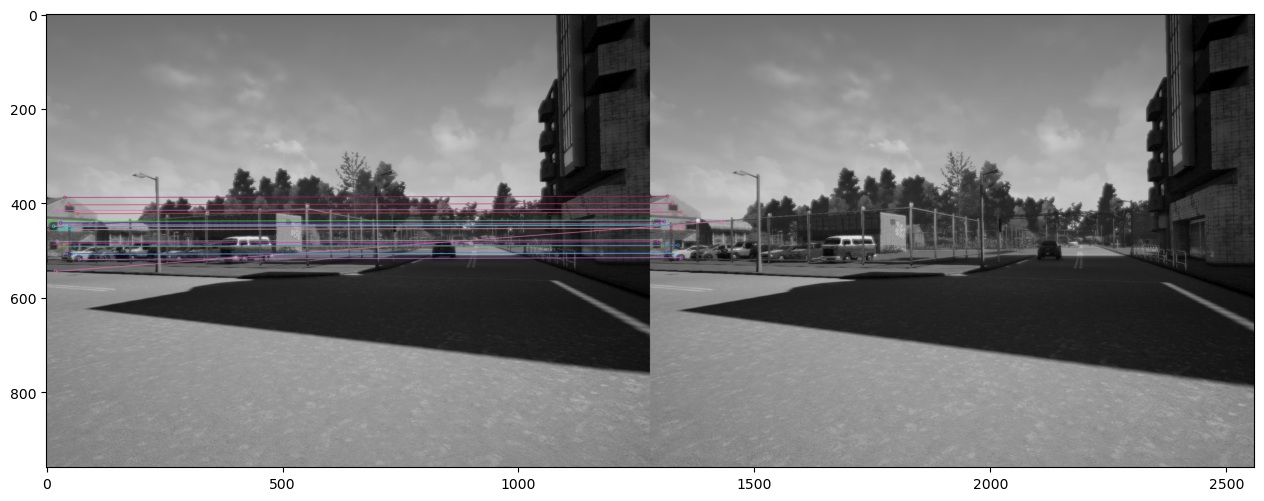

In [33]:
# Visualize n first matches, set n to None to view all matches
# set filtering to True if using match filtering, otherwise set to False
n = 20
filtering = True

i = 0 
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
if filtering:
    dist_threshold = 0.6
    match = filter_matches_distance(match, dist_threshold)

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])    

### 2.2 - Matching Features in Each Subsequent Image Pair in the Dataset

Implement feature matching for each subsequent image pair in the dataset.


In [34]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
               
    """
    matches = []
    
    ### START CODE HERE ###
    for i in range(len(des_list)-1):
        descriptor1 = des_list[i]
        descriptor2 = des_list[i+1]
        match = match_features(descriptor1, descriptor2)
        matches.append(match)
    ### END CODE HERE ###
    
    return matches

In [35]:
matches = match_features_dataset(des_list, match_features)

i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of features matched in frames 0 and 1: 1508


In [36]:
# Optional
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    filtered_matches = []
    
    ### START CODE HERE ###
    for m in matches:
        new_match = filter_matches_distance(m, dist_threshold)
        filtered_matches.append(new_match)
    ### END CODE HERE ###
    
    return filtered_matches

In [37]:
# Optional
dist_threshold = 0.6

filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)

if len(filtered_matches) > 0:
    
    # Make sure that this variable is set to True if you want to use filtered matches further in your assignment
    is_main_filtered_m = True
    if is_main_filtered_m: 
        matches = filtered_matches

    i = 0
    print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))

Number of filtered matches in frames 0 and 1: 409


## 3 - Trajectory Estimation

At this point you have everything to perform visual odometry for the autonomous vehicle. In this section you will incrementally estimate the pose of the vehicle by examining the changes that motion induces on the images of its onboard camera.

### 3.1 - Estimating Camera Motion between a Pair of Images

Implement camera motion estimation from a pair of images. You can use  Essential Matrix Decomposition.



In [38]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    
    ### START CODE HERE ###
    for m in match:
#         m = m[0]
        train_idx = m.trainIdx
        query_idx = m.queryIdx
        
        p1x, p1y = kp1[query_idx].pt
        image1_points.append([p1x, p1y])

        p2x, p2y = kp2[train_idx].pt
        image2_points.append([p2x, p2y])

    E, mask = cv2.findEssentialMat(np.array(image1_points), np.array(image2_points), k)
    
    retval, rmat, tvec, mask = cv2.recoverPose(E, np.array(image1_points), np.array(image2_points), k)
    ### END CODE HERE ###
    
    return rmat, tvec, image1_points, image2_points

In [39]:
i = 30
match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = dataset_handler.k
depth = dataset_handler.depth_maps[i]

rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

Estimated rotation:
 [[ 0.99923888  0.01170741  0.03721015]
 [-0.01157367  0.99992577 -0.00380764]
 [-0.03725197  0.00337408  0.99930021]]
Estimated translation:
 [[ 0.20902499]
 [ 0.02427009]
 [-0.97760908]]


**Camera Movement Visualization**:
You can use `visualize_camera_movement`, This function visualizes final image matches from an image pair connected with an arrow corresponding to direction of camera movement (when `is_show_img_after_mov = False`). The function description:


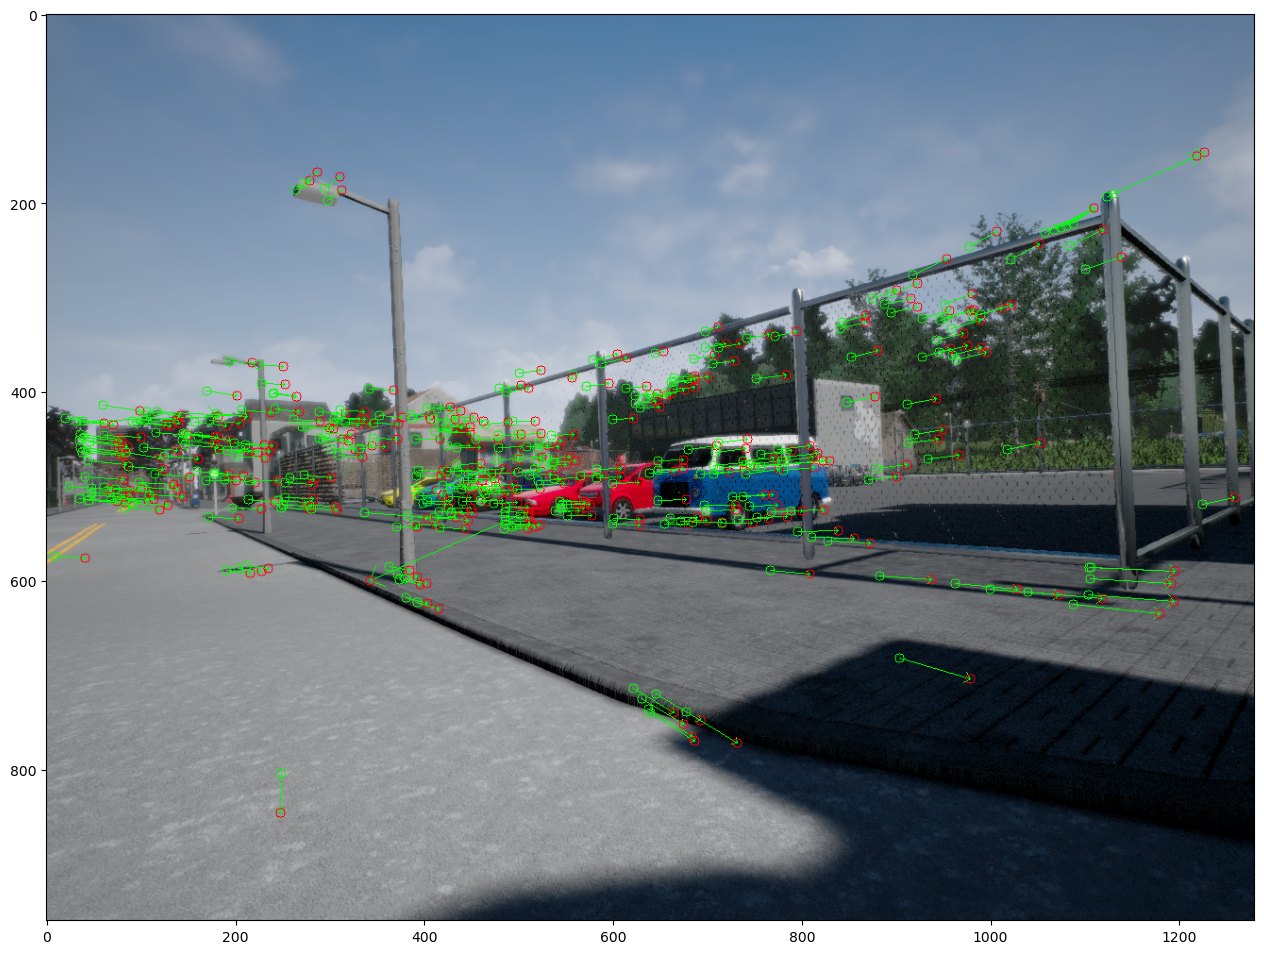

In [40]:
i=30
image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i + 1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

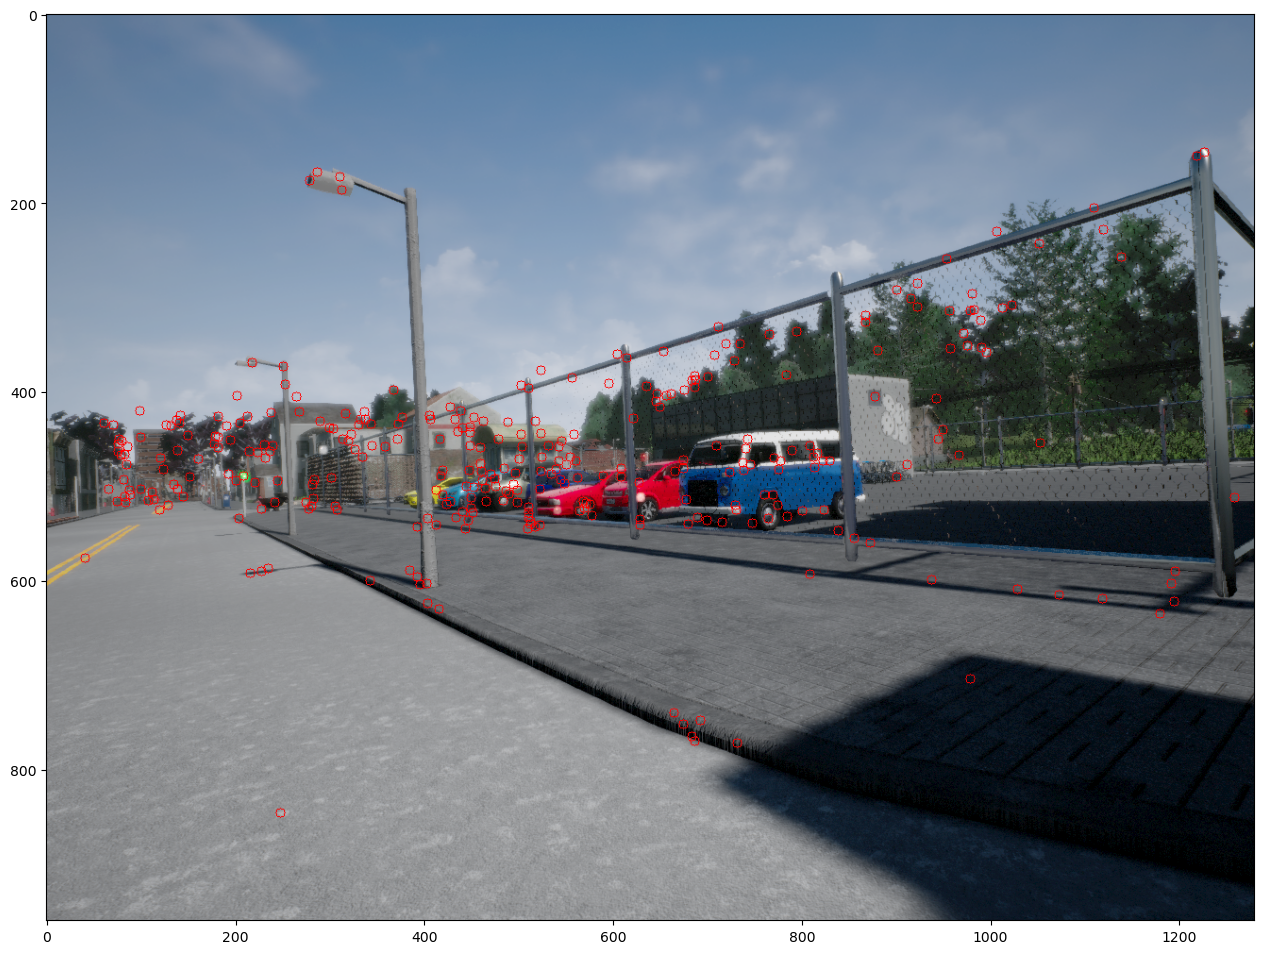

In [41]:
image_move = visualize_camera_movement(image1, image1_points, image2, image2_points, is_show_img_after_move=True)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)
# These visualizations might be helpful for understanding the quality of image points selected for the camera motion estimation

### 3.2 - Camera Trajectory Estimation

Implement camera trajectory estimation with visual odometry. More specifically, implement camera motion estimation for each subsequent image pair in the dataset with the function you wrote in the above section.


In [42]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=[]):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix 
    
    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location
                  
                  * Consider that the origin of your trajectory cordinate system is located at the camera position 
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven 
                  at the initialization of this function

    """
#     trajectory = [np.zeros((3, 1))]
    trajectory = [np.array([0, 0, 0])]
    
    ### START CODE HERE ###
    R = np.diag([1,1,1])
    T = np.zeros([3, 1])
    RT = np.hstack([R, T])
    RT = np.vstack([RT, np.zeros([1, 4])])
    RT[-1, -1] = 1
    
    for i in range(len(matches)):     
        match = matches[i]
        kp1 = kp_list[i]
        kp2 = kp_list[i+1]
        depth = depth_maps[i]
        
        rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth)
        rt_mtx = np.hstack([rmat, tvec])
        rt_mtx = np.vstack([rt_mtx, np.zeros([1, 4])])
        rt_mtx[-1, -1] = 1
        
#         https://docs.opencv.org/3.4.3/d9/dab/tutorial_homography.html
        rt_mtx_inv = np.linalg.inv(rt_mtx)
        
        RT = np.dot(RT, rt_mtx_inv)
        new_trajectory = RT[:3, 3]
        trajectory.append(new_trajectory)
    
    trajectory = np.array(trajectory).T
    ### END CODE HERE ###
    
    return trajectory

In [43]:
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)

i = 1
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

Camera location in point 1 is: 
 [[-0.16118717]
 [-0.01698477]
 [ 0.98677769]]

Length of trajectory: 52


In [44]:
# Note: Make sure to uncomment the below line if you modified the original data in any ways
#dataset_handler = DatasetHandler()


# Part 1. Features Extraction
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)


# Part II. Feature Matching
matches = match_features_dataset(des_list, match_features)

# Set to True if you want to use filtered matches or False otherwise
is_main_filtered_m = True
if is_main_filtered_m:
    dist_threshold = 0.75
    filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)
    matches = filtered_matches

    
# Part III. Trajectory Estimation
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)


#!!! Make sure you don't modify the output in any way
# Print Submission Info
print("Trajectory X:\n {0}".format(trajectory[0,:].reshape((1,-1))))
print("Trajectory Y:\n {0}".format(trajectory[1,:].reshape((1,-1))))
print("Trajectory Z:\n {0}".format(trajectory[2,:].reshape((1,-1))))

Trajectory X:
 [[ 0.00000000e+00 -3.78644463e-02 -2.13936457e-02 -9.29229223e-02
   2.77282284e-02  2.09036124e-02  6.79919918e-02 -1.42704253e-01
  -2.29131832e-01 -2.14178118e-01 -2.60545748e-01 -6.89863236e-01
  -8.04039694e-01 -1.04410390e+00 -1.25231144e+00 -1.73798605e+00
  -2.23502109e+00 -2.58142949e+00 -2.96182894e+00 -3.21211351e+00
  -3.56271187e+00 -3.99537084e+00 -4.53196952e+00 -5.14391907e+00
  -5.68420470e+00 -6.29039799e+00 -6.87779310e+00 -7.35885716e+00
  -7.85026610e+00 -8.36146477e+00 -8.99058561e+00 -9.67595209e+00
  -1.04053104e+01 -1.11532179e+01 -1.19590913e+01 -1.28371897e+01
  -1.37665560e+01 -1.47143183e+01 -1.56864698e+01 -1.66816912e+01
  -1.76748072e+01 -1.86695425e+01 -1.96690483e+01 -2.06644086e+01
  -2.16635060e+01 -2.26497499e+01 -2.35901585e+01 -2.45341057e+01
  -2.54650245e+01 -2.63216695e+01 -2.71625763e+01 -2.79648580e+01]]
Trajectory Y:
 [[ 0.         -0.00768371  0.06429275  0.10076092  0.05177835 -0.04412551
  -0.06356703 -0.05111298 -0.0541796

### Visualize your Results


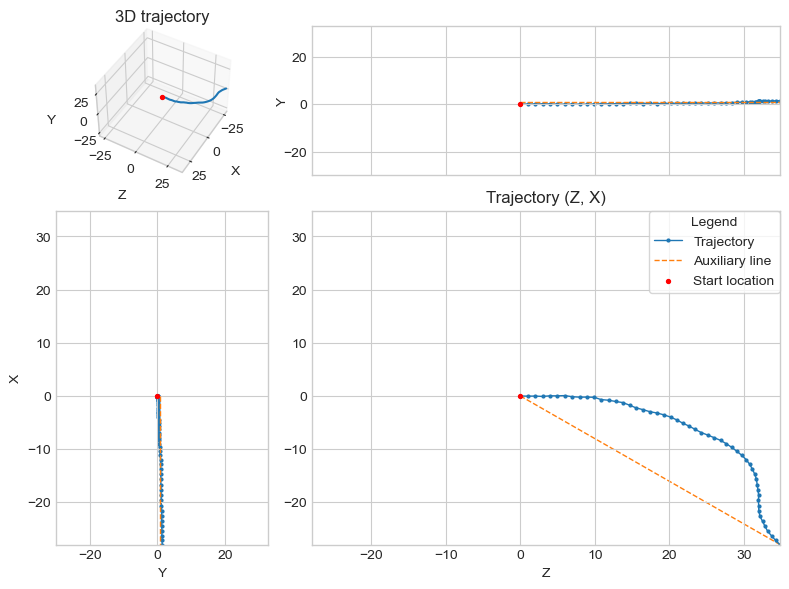

In [45]:
visualize_trajectory(trajectory)